## Import Libraries

In [1]:
import os
import random
from PIL import Image

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# Paths
IMG_DIR = r"C:\Users\Nucliedo\Desktop\Imarticus Learning\Capstone Project - 2\Facial_Recognition\img_align_celeba"
attr_df = pd.read_csv(r"C:\Users\Nucliedo\Desktop\Imarticus Learning\Capstone Project - 2\Facial_Recognition\list_attr_celeba.csv")

In [3]:
attr_df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [4]:
attr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   image_id             202599 non-null  object
 1   5_o_Clock_Shadow     202599 non-null  int64 
 2   Arched_Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags_Under_Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big_Lips             202599 non-null  int64 
 8   Big_Nose             202599 non-null  int64 
 9   Black_Hair           202599 non-null  int64 
 10  Blond_Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown_Hair           202599 non-null  int64 
 13  Bushy_Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double_Chin          202599 non-nu

In [5]:
attr_df.isnull().sum()

image_id               0
5_o_Clock_Shadow       0
Arched_Eyebrows        0
Attractive             0
Bags_Under_Eyes        0
Bald                   0
Bangs                  0
Big_Lips               0
Big_Nose               0
Black_Hair             0
Blond_Hair             0
Blurry                 0
Brown_Hair             0
Bushy_Eyebrows         0
Chubby                 0
Double_Chin            0
Eyeglasses             0
Goatee                 0
Gray_Hair              0
Heavy_Makeup           0
High_Cheekbones        0
Male                   0
Mouth_Slightly_Open    0
Mustache               0
Narrow_Eyes            0
No_Beard               0
Oval_Face              0
Pale_Skin              0
Pointy_Nose            0
Receding_Hairline      0
Rosy_Cheeks            0
Sideburns              0
Smiling                0
Straight_Hair          0
Wavy_Hair              0
Wearing_Earrings       0
Wearing_Hat            0
Wearing_Lipstick       0
Wearing_Necklace       0
Wearing_Necktie        0


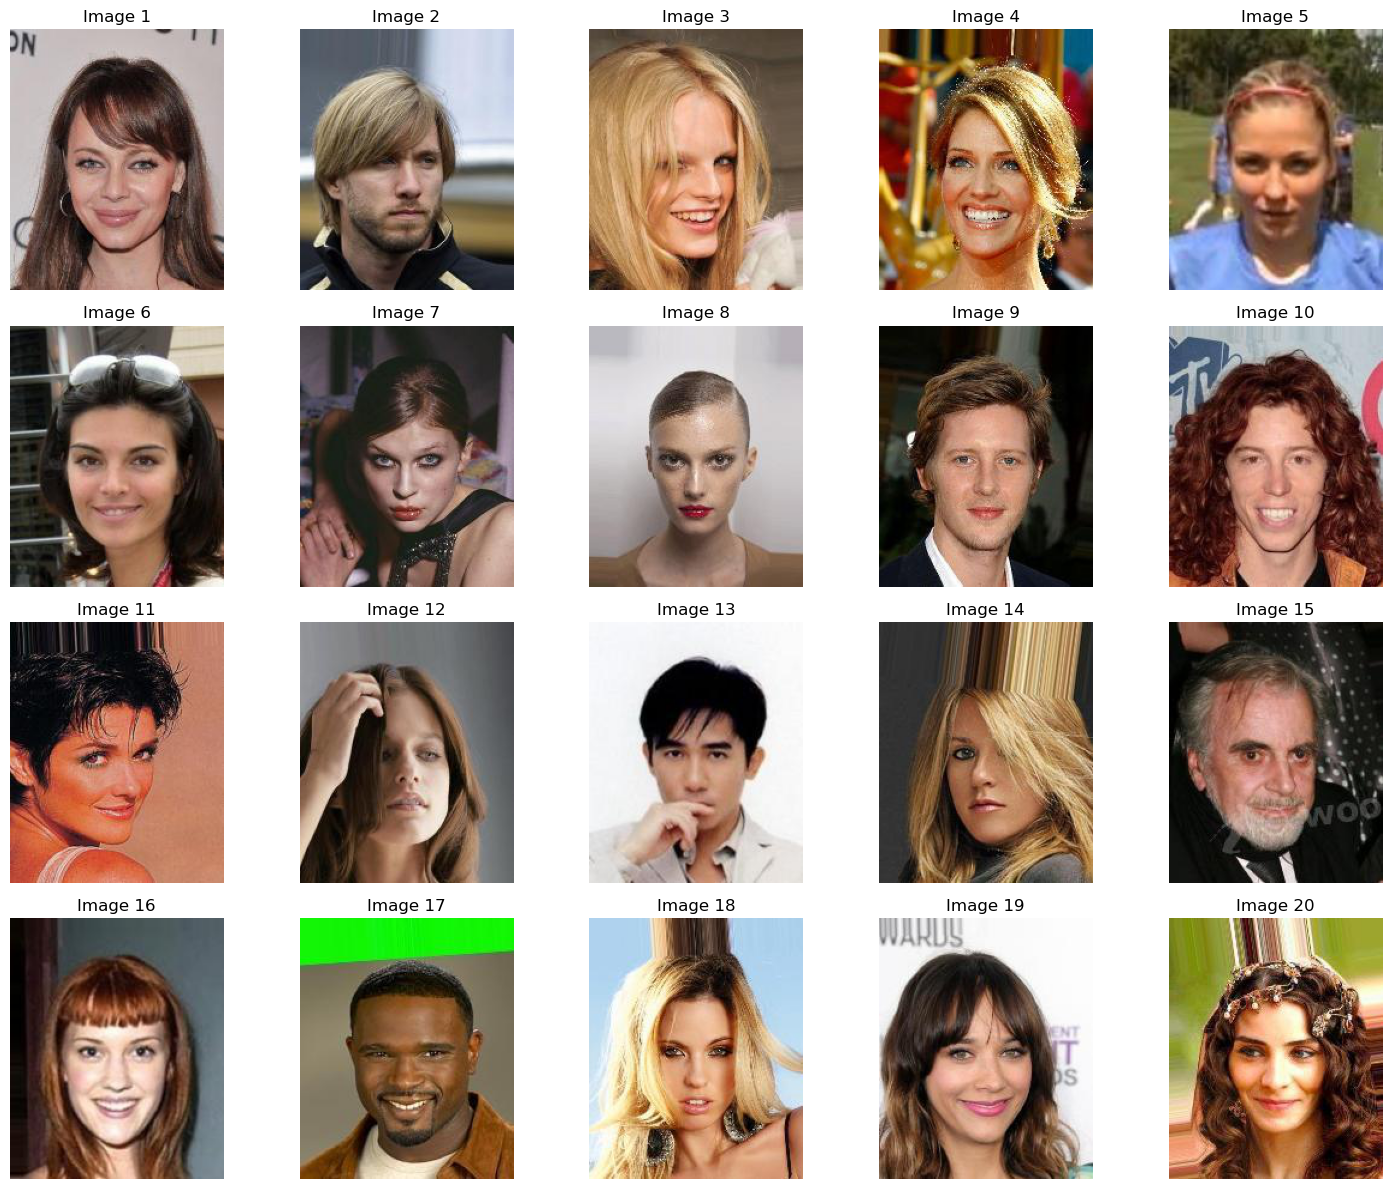

In [6]:
# Define the number of rows and columns for the grid
rows, cols = 4, 5

# Get all image file names from IMG_DIR
image_files = [img for img in os.listdir(IMG_DIR) if img.lower().endswith(("png", "jpg", "jpeg"))]

# Randomly select 20 images
random_images = random.sample(image_files, min(len(image_files), 20))

# Create a figure for the grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

# Loop through the axes and display images
for i, ax in enumerate(axes.flat):
    if i < len(random_images):
        img_path = os.path.join(IMG_DIR, random_images[i])
        img = Image.open(img_path).convert("RGB")
        ax.imshow(img)
        ax.set_title("Image {}".format(i + 1))
        ax.axis("off")  # Hide the axes
    else:
        ax.axis("off")  # Hide empty plots

plt.tight_layout()
plt.show()

## Set Configurations

In [7]:
# Settings
IMAGE_SIZE = 64
BATCH_SIZE = 64
EPOCHS = 30

## Load and Prepare Data

In [8]:
# Select attributes
attributes = [
    "Male", "Smiling", "Young", "Eyeglasses", "No_Beard",
    "Wavy_Hair", "Blond_Hair", "Heavy_Makeup"
]

labels = attr_df[attributes].values
labels = (labels == 1).astype(float)

# Load images
images = []
for img_name in attr_df.iloc[:, 0]:
    img_path = os.path.join(IMG_DIR, img_name)
    img = Image.open(img_path).convert("RGB")
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img = np.array(img) / 255.0
    images.append(img)
images = np.array(images)

# Split data
split = int(0.8 * len(images))
train_images, test_images = images[:split], images[split:]
train_labels, test_labels = labels[:split], labels[split:]

## Compute Class Weights

In [9]:
class_weights_list = []
for i in range(labels.shape[1]):
    class_weights = compute_class_weight(
        class_weight="balanced", 
        classes=np.unique(train_labels[:, i]), 
        y=train_labels[:, i]
    )
    class_weights_list.append({0: class_weights[0], 1: class_weights[1]})

## Define Custom Loss Function

In [10]:
def weighted_binary_crossentropy(class_weights_list):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        losses = []
        for i in range(len(class_weights_list)):
            weights = tf.where(tf.equal(y_true[:, i], 1),
                               tf.cast(class_weights_list[i][1], tf.float32),
                               tf.cast(class_weights_list[i][0], tf.float32))
            bce = tf.keras.losses.binary_crossentropy(y_true[:, i], y_pred[:, i])
            losses.append(bce * weights)
        return tf.reduce_mean(tf.stack(losses, axis=-1))
    return loss

## Build and Compile Model

In [11]:
model = tf.keras.Sequential([
    layers.Conv2D(32, 3, activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(attributes), activation="sigmoid")  # One output per attribute
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=weighted_binary_crossentropy(class_weights_list),
    metrics=["accuracy"]
)

C:\Users\Nucliedo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Train the Model

In [12]:
history = model.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/30
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 247s 94ms/step - accuracy: 0.2907 - loss: 0.3455 - val_accuracy: 0.3646 - val_loss: 0.2261
Epoch 2/30
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 224s 88ms/step - accuracy: 0.3677 - loss: 0.2165 - val_accuracy: 0.3897 - val_loss: 0.2055
Epoch 3/30
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 224s 88ms/step - accuracy: 0.3848 - loss: 0.2016 - val_accuracy: 0.3730 - val_loss: 0.2025
Epoch 4/30
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 195s 77ms/step - accuracy: 0.3911 - loss: 0.1920 - val_accuracy: 0.4031 - val_loss: 0.1957
Epoch 5/30
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 199s 78ms/step - accuracy: 0.4121 - loss: 0.1851 - val_accuracy: 0.3451 - val_loss: 0.1964
Epoch 6/30
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 192s 76ms/step - accuracy: 0.4059 - loss: 0.1801 - val_accuracy: 0.3807 - val_loss: 0.1949
Epoch 7/30
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 193s 76ms/step - accuracy: 0.4085 - loss: 0.1770 - val_accuracy: 0.4061 - val_loss: 0.1983
Epoch 8/30
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 189s 75ms/step - accuracy: 

## Evaluate Model and Calculate Metrics

In [13]:
test_predictions = model.predict(test_images)
test_predictions = (test_predictions > 0.5).astype(int)

print("\nMetrics for Each Attribute:")
for i, attribute in enumerate(attributes):
    acc = accuracy_score(test_labels[:, i], test_predictions[:, i])
    precision = precision_score(test_labels[:, i], test_predictions[:, i])
    recall = recall_score(test_labels[:, i], test_predictions[:, i])
    f1 = f1_score(test_labels[:, i], test_predictions[:, i])
    print("{} - Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1-Score: {:.3f}".format(attribute, acc, precision, recall, f1))


flat_labels = test_labels.flatten()
flat_predictions = test_predictions.flatten()
combined_accuracy = accuracy_score(flat_labels, flat_predictions)
combined_precision = precision_score(flat_labels, flat_predictions)
combined_recall = recall_score(flat_labels, flat_predictions)
combined_f1 = f1_score(flat_labels, flat_predictions)

print("\nCombined Metrics:")
print("Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1-Score: {:.3f}".format(combined_accuracy, combined_precision, combined_recall, combined_f1))

1267/1267 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step

Metrics for Each Attribute:
Male - Accuracy: 0.975, Precision: 0.968, Recall: 0.969, F1-Score: 0.969
Smiling - Accuracy: 0.918, Precision: 0.926, Recall: 0.905, F1-Score: 0.915
Young - Accuracy: 0.863, Precision: 0.884, Recall: 0.940, F1-Score: 0.911
Eyeglasses - Accuracy: 0.990, Precision: 0.955, Recall: 0.900, F1-Score: 0.927
No_Beard - Accuracy: 0.941, Precision: 0.964, Recall: 0.966, F1-Score: 0.965
Wavy_Hair - Accuracy: 0.819, Precision: 0.822, Recall: 0.557, F1-Score: 0.664
Blond_Hair - Accuracy: 0.950, Precision: 0.829, Recall: 0.824, F1-Score: 0.826
Heavy_Makeup - Accuracy: 0.902, Precision: 0.874, Recall: 0.881, F1-Score: 0.878

Combined Metrics:
Accuracy: 0.920, Precision: 0.914, Recall: 0.897, F1-Score: 0.905


## Visualize Training History and Confusion Matrix

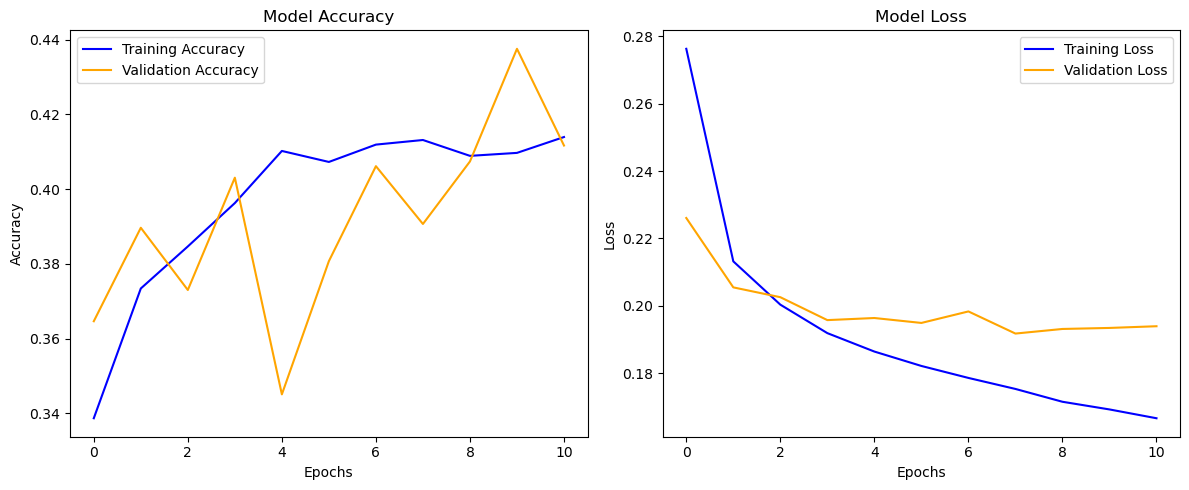

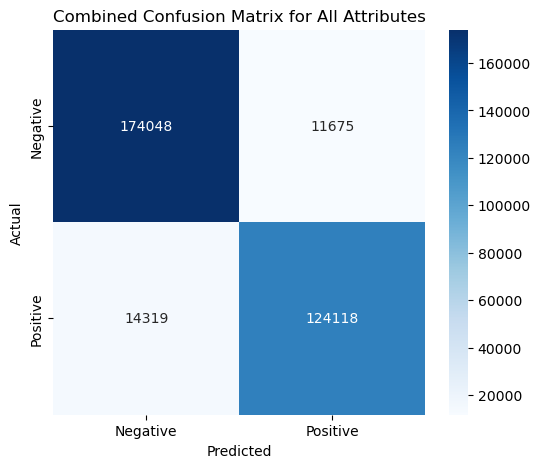

In [14]:
# Plot model accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy", color="blue")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Confusion matrix
combined_cm = confusion_matrix(flat_labels, flat_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(combined_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Combined Confusion Matrix for All Attributes")
plt.show()

## Predict Attributes for a Single Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


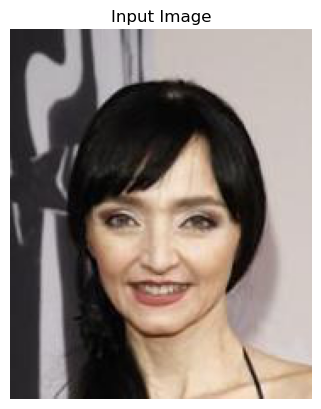


Predictions for the Image:
Gender : Female
Expression : Smiling
Appearance : Young
Eyewear : No Eyeglasses
Facial Hair : No
Hair : Straight Hair
Hair Color : Dark Hair
Makeup : Heavy Makeup


In [20]:
image_path = r"C:\Users\Nucliedo\Desktop\Imarticus Learning\Capstone Project - 2\Facial_Recognition\img (12).jpg"

def predict_image_attributes_structured(image_path, model, attributes):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predictions = (predictions > 0.5).astype(int).flatten()

    structured_predictions = {
        "Gender": "Male" if predictions[attributes.index("Male")] else "Female",
        "Expression": "Smiling" if predictions[attributes.index("Smiling")] else "Neutral",
        "Appearance": "Young" if predictions[attributes.index("Young")] else "Old",
        "Eyewear": "Wearing Eyeglasses" if predictions[attributes.index("Eyeglasses")] else "No Eyeglasses",
        "Facial Hair": "No" if predictions[attributes.index("No_Beard")] else "Yes",
        "Hair": "Wavy Hair" if predictions[attributes.index("Wavy_Hair")] else "Straight Hair",
        "Hair Color": "Blond Hair" if predictions[attributes.index("Blond_Hair")] else "Dark Hair",
        "Makeup": "Heavy Makeup" if predictions[attributes.index("Heavy_Makeup")] else "No Makeup"
    }
    return structured_predictions

structured_predictions = predict_image_attributes_structured(image_path, model, attributes)

# Display the image and predictions
img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")
plt.title("Input Image")
plt.show()

print("\nPredictions for the Image:")
for category, prediction in structured_predictions.items():
    print(category,":", prediction)

In [17]:
model.save("model.h5")